# CS 20 : TensorFlow for Deep Learning Research
## Lecture 05 : Variable sharing and managing experiments
### Applied example with tf.data
Ref : [Toward Best Practices of TensorFlow Code Patterns](https://wookayin.github.io/TensorFlowKR-2017-talk-bestpractice/ko/#1) by Jongwook Choi, Beomjun Shin  

- Using **high-level api** `tf.keras.layers`
- Creating the **input pipeline** with `tf.data`
- Creating the model as **Class**
- Training the model with **learning rate scheduling** by exponential decay learning rate
- Saving the model and Restoring the model

### Setup

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
%matplotlib inline

print(tf.__version__)

1.12.0


### Load and Pre-process data

In [2]:
(x_train, y_train), (x_tst, y_tst) = keras.datasets.mnist.load_data()
x_train = x_train  / 255
x_train = x_train.reshape(-1, 784)
x_tst = x_tst / 255
x_tst = x_tst.reshape(-1, 784)

In [3]:
tr_indices = np.random.choice(range(x_train.shape[0]), size = 55000, replace = False)

x_tr = x_train[tr_indices]
y_tr = y_train[tr_indices]

x_val = np.delete(arr = x_train, obj = tr_indices, axis = 0)
y_val = np.delete(arr = y_train, obj = tr_indices, axis = 0)

print(x_tr.shape, y_tr.shape)
print(x_val.shape, y_val.shape)

(55000, 784) (55000,)
(5000, 784) (5000,)


### Define DNN Classifier with two hidden layer

In [4]:
class DNNClassifier:
    def __init__(self, X, y, n_of_classes, hidden_dims = [100, 50], name = 'DNN'):
        
        with tf.variable_scope(name):
            with tf.variable_scope('input_layer'):
                self.X = X
                self.y = y
        
            h = self.X

            for layer, h_dim in enumerate(hidden_dims):
                with tf.variable_scope('hidden_layer_{}'.format(layer + 1)):
                    h = keras.layers.Dense(units = h_dim, activation = keras.activations.tanh,
                                           kernel_initializer = keras.initializers.VarianceScaling())(h)
        
            with tf.variable_scope('output_layer'):
                score = keras.layers.Dense(units = n_of_classes)(h)
        
            with tf.variable_scope('ce_loss'):
                self.loss = tf.losses.sparse_softmax_cross_entropy(labels = self.y,
                                                                   logits = score)
                
            with tf.variable_scope('prediction'):
                self.__prediction = tf.argmax(input = score, axis = 1)
    
    def predict(self, sess, X):
        feed_predict = {self.X : X}
        return sess.run(fetches = self.__prediction, feed_dict = feed_predict)

### Create a model of DNN Classifier

In [5]:
# hyper-parameter
epochs = 15
batch_size = 64
learning_rate = .005
total_step = int(x_tr.shape[0] / batch_size)
print(total_step)

859


In [6]:
## create input pipeline with tf.data
# for train
tr_dataset = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
tr_dataset = tr_dataset.shuffle(buffer_size = 10000)
tr_dataset = tr_dataset.batch(batch_size = batch_size)
tr_iterator = tr_dataset.make_initializable_iterator()
print(tr_dataset)

# for validation
val_dataset = tf.data.Dataset.from_tensor_slices((x_val,y_val))
val_dataset = val_dataset.batch(batch_size = batch_size)
val_iterator = val_dataset.make_initializable_iterator()
print(val_dataset)

<BatchDataset shapes: ((?, 784), (?,)), types: (tf.float64, tf.uint8)>
<BatchDataset shapes: ((?, 784), (?,)), types: (tf.float64, tf.uint8)>


In [8]:
## define Iterator
# tf.data.Iterator.from_string_handle의 output_shapes는 default = None이지만 꼭 값을 넣는 게 좋음
handle = tf.placeholder(dtype = tf.string)
iterator = tf.data.Iterator.from_string_handle(string_handle = handle,
                                               output_types = tr_iterator.output_types,
                                               output_shapes = tr_iterator.output_shapes)

x_data, y_data = iterator.get_next()
x_data = tf.cast(x_data, dtype = tf.float32)
y_data = tf.cast(y_data, dtype = tf.int32)

In [9]:
dnn = DNNClassifier(X = x_data, y = y_data, n_of_classes = 10)

### Create training op and train model
Applying exponential decay learning rate to train DNN model  
```python
decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)

```
Ref : https://www.tensorflow.org/api_docs/python/tf/train/exponential_decay

In [10]:
## Applying exponential decay learning rate to train dnn model
global_step = tf.Variable(initial_value = 0 , trainable = False)
exp_decayed_lr = tf.train.exponential_decay(learning_rate = learning_rate,
                                            global_step = global_step,
                                            decay_steps = total_step * 5,
                                            decay_rate = .9,
                                            staircase = True)

In [11]:
# create training op
opt = tf.train.AdamOptimizer(learning_rate = exp_decayed_lr)

# equal to 'var_list = None'
training_op = opt.minimize(loss = dnn.loss,
                           var_list = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES),
                           global_step = global_step) 

# create summary op for tensorboard
loss_summ = tf.summary.scalar(name = 'loss', tensor = dnn.loss)

In [12]:
train_writer = tf.summary.FileWriter(logdir = '../graphs/lecture05/applied_example_wd/train',
                                     graph = tf.get_default_graph())
val_writer = tf.summary.FileWriter(logdir = '../graphs/lecture05/applied_example_wd/val',
                                     graph = tf.get_default_graph())
saver = tf.train.Saver()

In [13]:
# epochs = 15
# batch_size = 64
# total_step = int(x_tr.shape[0] / batch_size)
sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
sess = tf.Session(config = sess_config)
sess.run(tf.global_variables_initializer())
tr_handle, val_handle = sess.run(fetches = [tr_iterator.string_handle(), val_iterator.string_handle()])

tr_loss_hist = []
val_loss_hist = []

for epoch in range(epochs):

    avg_tr_loss = 0
    avg_val_loss = 0
    tr_step = 0
    val_step = 0
    
    # for mini-batch training
    sess.run(tr_iterator.initializer)
    try:
        while True:
            _, tr_loss,tr_loss_summ = sess.run(fetches = [training_op, dnn.loss, loss_summ],
                                               feed_dict = {handle : tr_handle})
            avg_tr_loss += tr_loss
            tr_step += 1
            
    except tf.errors.OutOfRangeError:
        pass
    
    # for validation
    sess.run(val_iterator.initializer)
    try:
        while True:
            val_loss, val_loss_summ = sess.run(fetches = [dnn.loss, loss_summ],
                                                          feed_dict = {handle : val_handle})
            avg_val_loss += val_loss
            val_step += 1
            
    except tf.errors.OutOfRangeError:
        pass
    
    train_writer.add_summary(tr_loss_summ, global_step = (epoch + 1))
    val_writer.add_summary(val_loss_summ, global_step = (epoch + 1))

    avg_tr_loss /= tr_step
    avg_val_loss /= val_step
    tr_loss_hist.append(avg_tr_loss)
    val_loss_hist.append(avg_val_loss)
    
    if (epoch + 1) % 5 == 0:
        print('epoch : {:3}, tr_loss : {:.2f}, val_loss : {:.2f}'.format(epoch + 1, avg_tr_loss, avg_val_loss))
        saver.save(sess = sess, save_path = '../graphs/lecture05/applied_example_wd/dnn', global_step = (epoch + 1))

train_writer.close()
val_writer.close()

epoch :   5, tr_loss : 0.09, val_loss : 0.12
epoch :  10, tr_loss : 0.07, val_loss : 0.12
epoch :  15, tr_loss : 0.05, val_loss : 0.11


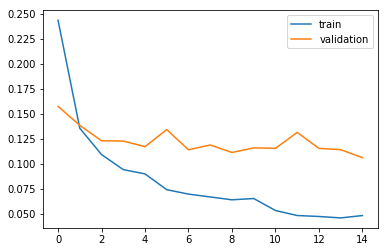

In [14]:
plt.plot(tr_loss_hist, label = 'train')
plt.plot(val_loss_hist, label = 'validation')
plt.legend()

In [15]:
yhat = dnn.predict(sess = sess, X = x_tst)
print('test acc: {:.2%}'.format(np.mean(yhat == y_tst)))
sess.close()

test acc: 97.11%


### Restore model

#### Example 1
Restore my model at epoch 15

In [16]:
tf.reset_default_graph()

x_data = tf.placeholder(dtype = tf.float32, shape = [None, 784])
y_data = tf.placeholder(dtype = tf.int32, shape = [None])

dnn_restore = DNNClassifier(X = x_data, y = y_data, n_of_classes = 10)

In [17]:
ckpt_list = tf.train.get_checkpoint_state(checkpoint_dir = '../graphs/lecture05/applied_example_wd/')
print(ckpt_list) 

model_checkpoint_path: "../graphs/lecture05/applied_example_wd/dnn-15"
all_model_checkpoint_paths: "../graphs/lecture05/applied_example_wd/dnn-5"
all_model_checkpoint_paths: "../graphs/lecture05/applied_example_wd/dnn-10"
all_model_checkpoint_paths: "../graphs/lecture05/applied_example_wd/dnn-15"



In [18]:
# restore my model at epoch 15
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess = sess, save_path = '../graphs/lecture05/applied_example_wd/dnn-15')

INFO:tensorflow:Restoring parameters from ../graphs/lecture05/applied_example_wd/dnn-15


In [19]:
yhat = dnn_restore.predict(sess = sess, X = x_tst)
print('test acc: {:.2%}'.format(np.mean(yhat == y_tst)))
sess.close()

test acc: 97.11%


#### Example 2
Restore my model at epoch 10

In [20]:
tf.reset_default_graph()

x_data = tf.placeholder(dtype = tf.float32, shape = [None, 784])
y_data = tf.placeholder(dtype = tf.int32, shape = [None])

dnn_restore = DNNClassifier(X = x_data, y = y_data, n_of_classes = 10)

In [21]:
ckpt_list = tf.train.get_checkpoint_state(checkpoint_dir = '../graphs/lecture05/applied_example_wd/')
print(ckpt_list) 

model_checkpoint_path: "../graphs/lecture05/applied_example_wd/dnn-15"
all_model_checkpoint_paths: "../graphs/lecture05/applied_example_wd/dnn-5"
all_model_checkpoint_paths: "../graphs/lecture05/applied_example_wd/dnn-10"
all_model_checkpoint_paths: "../graphs/lecture05/applied_example_wd/dnn-15"



In [22]:
# restore my model at epoch 10
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess = sess, save_path = '../graphs/lecture05/applied_example_wd/dnn-10')

INFO:tensorflow:Restoring parameters from ../graphs/lecture05/applied_example_wd/dnn-10


In [23]:
yhat = dnn_restore.predict(sess = sess, X = x_tst)
print('test acc: {:.2%}'.format(np.mean(yhat == y_tst)))
sess.close()

test acc: 96.79%
